In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [31]:
# configure plots
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 6, 4

# Data

## Raw Data

In [11]:
X = pd.read_csv('./4_Station/X.csv', index_col=0)
y = pd.read_csv('./4_Station/y.csv', index_col=0)

## Normalize

In [12]:
scaler = MinMaxScaler(feature_range=(-1, 1))
y_standard = scaler.fit_transform(pd.DataFrame(y['pt']))
y_standard = pd.DataFrame(y_standard, columns=['pt_s'], index=y.index)
y['pt_s'] = y_standard['pt_s']

In [18]:
X = X.fillna(0)

## Train Test Split

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

# Models

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

In [21]:
X.shape

(138011, 27)

In [22]:
# 搭建模型
def create_model():
    classifier = Sequential()
    # 输入层及第一个隐藏层
    classifier.add(Dense(activation="tanh", 
                         input_dim=27, 
                         units=60, 
                         kernel_initializer="uniform"))
    # 第二个隐藏层
    classifier.add(Dense(activation="tanh", 
                         units=30, 
                         kernel_initializer="uniform"))
    # 第三个隐藏层
    classifier.add(Dense(activation="tanh", 
                         units=30, 
                         kernel_initializer="uniform"))
    # 输出层
    classifier.add(Dense(activation="tanh", 
                         units=1, 
                         kernel_initializer="uniform"))
    
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    classifier.compile(optimizer = 'adam', 
                       loss = 'mean_absolute_error', 
                       metrics = ['mse'])
    return classifier

model = KerasRegressor(build_fn=create_model)

In [23]:
model.fit(X_train,y_train['pt_s'], batch_size=10, epochs = 20)

Epoch 1/20
110408/110408 [==============================] - 18s 166us/step - loss: 0.3763 - mean_squared_error: 0.2242
Epoch 2/20
110408/110408 [==============================] - 17s 154us/step - loss: 0.2868 - mean_squared_error: 0.1460
Epoch 3/20
110408/110408 [==============================] - 17s 151us/step - loss: 0.2697 - mean_squared_error: 0.1331
Epoch 4/20
110408/110408 [==============================] - 17s 157us/step - loss: 0.2630 - mean_squared_error: 0.1281
Epoch 5/20
110408/110408 [==============================] - 19s 168us/step - loss: 0.2592 - mean_squared_error: 0.1249
Epoch 6/20
110408/110408 [==============================] - 18s 165us/step - loss: 0.2559 - mean_squared_error: 0.1226
Epoch 7/20
110408/110408 [==============================] - 17s 155us/step - loss: 0.2543 - mean_squared_error: 0.1214
Epoch 8/20
110408/110408 [==============================] - 17s 155us/step - loss: 0.2532 - mean_squared_error: 0.1207
Epoch 9/20
110408/110408 [======================

In [24]:
y_pred = model.predict(X_test)

# Visualization

## Gather Results

In [25]:
visual = y_test.reset_index()

In [26]:
visual['pt_pred'] = scaler.inverse_transform(pd.DataFrame(y_pred))

## Visualization Features

In [27]:
visual['q/pt_pred'] = visual['q'] / visual['pt_pred']

## Scatter

In [28]:
visual['delta_1/pt'] = 1/visual['pt'] - 1/visual['pt_pred']

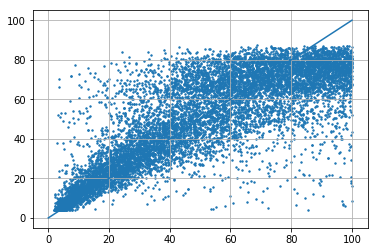

In [37]:
visual_sample = visual.sample(n = 10000)
fig, ax = plt.subplots()
line = [0, 100]
ax.plot(line, line)
ax.scatter(visual_sample['pt'], 
           visual_sample['pt_pred'], 
#            c = visual_sample['hit_count'], 
           cmap = 'copper', 
           s = 2, 
           alpha = 1
          )
# plt.ylim(-1, 1)
ax.grid(True)

In [42]:
visual['delta_1/pt'] = 1/visual['pt'] - 1/visual['pt_pred']

In [46]:
points = range(2, 100)
bias = []
resolution = []

In [47]:
for i in points:
    temp = visual[(visual['pt']>i) & (visual['pt']<i+1)]
    bias.append(temp['delta_1/pt'].mean())
    resolution.append(temp['delta_1/pt'].std())
#     resolution.append((temp['delta_1/pt'].max() - temp['delta_1/pt'].min())/2)

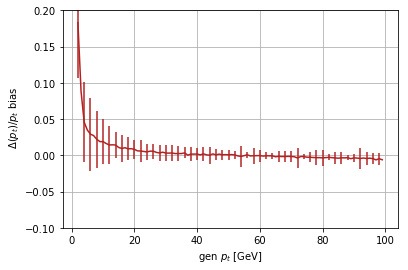

In [50]:
fig, ax = plt.subplots()
ax.errorbar(points, bias, color='firebrick', yerr=resolution, errorevery=2)
plt.ylim(-0.1, 0.2)
ax.set(xlabel=r'gen $p_t$ [GeV]', ylabel=r' $\Delta(p_t)/p_t$ bias')
ax.grid(True)
# ax.set_title('all errorbars')
fig.savefig('4s.jpg', format='jpg', dpi=900)

# Save Results

In [49]:
visual.to_csv('result_4s_nn_run1.csv')